# Busy stations for advertising - Darren Liu

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium as f
import numpy as np
import sqlite3 as sq
from datetime import datetime
from datetime import date

In [106]:
def get_data(sql, db):
    #connect database
    conn = sq.connect(db)
    sql_query = pd.read_sql_query(sql, conn)
    df = pd.DataFrame(sql_query)
    # get coords data
    coords = pd.read_csv('coords.csv')
    name = coords.NAME
    df = df[df['STATION'].isin(name)]
    
    return df

In [107]:
# get the data from database
df = get_data('''
        SELECT *
        FROM mta_data
        ''', 'mta_data.db')

In [108]:
#drop na rows
df.dropna()
# convert date and time to datetime
df['DATE_TIME'] = pd.to_datetime(df.DATE + ' ' + df.TIME)

df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,03:00:00,REGULAR,7672966,2645023,2021-12-18 03:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,07:00:00,REGULAR,7672969,2645040,2021-12-18 07:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,11:00:00,REGULAR,7672991,2645127,2021-12-18 11:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,15:00:00,REGULAR,7673037,2645193,2021-12-18 15:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,19:00:00,REGULAR,7673097,2645270,2021-12-18 19:00:00


In [182]:
# coordinates of universities in nyc
uni_coords = pd.DataFrame()
uni_coords['NAME'] = ['NYU', 'CC', 'SUNY', 'SPU', 'SVA', 'SJU']
uni_coords['lon'] = [40.73006592702323, 40.80493647708624, 40.69241067791467, 40.72909625075351, 40.73883524176659, 40.68789723938327]
uni_coords['lat'] = [-73.99658967354122, -73.96055570627733, -73.98974479534301, -74.07038441606242, -73.98231897482766, -73.85593296359626]

# coordinates of companies in nyc
com_coords = pd.DataFrame()
com_coords['NAME'] = ['JPMorgan Chase & Co', 'ABM Industries', 'ABM Industries', 'ABM Industries', 'Pfizer']
com_coords['lon'] = [40.7579596354102, 40.75267938737633, 40.71183447682946, 40.766852171686196, 40.700008223565355]
com_coords['lat'] = [-73.97523428921932, -73.98754381753042, -74.0112330866523, -73.91081118494, -73.9481595411773]

In [183]:
uni_coords

,NAME,lon,lat
0,NYU,40.730066,-73.996590
1,CC,40.804936,-73.960556
2,SUNY,40.692411,-73.989745
3,SPU,40.729096,-74.070384
4,SVA,40.738835,-73.982319
5,SJU,40.687897,-73.855933


In [184]:
com_coords

,NAME,lon,lat
0,JPMorgan Chase & Co,40.757960,-73.975234
1,ABM Industries,40.752679,-73.987544
2,ABM Industries,40.711834,-74.011233
3,ABM Industries,40.766852,-73.910811
4,Pfizer,40.700008,-73.948160


In [109]:
# create daily traffic for each station (traffic = entries + exits)

def daily_traffic(df):
    df['TRAFFIC'] = (df['ENTRIES'] + df['EXITS']).astype('int64')
    new_df = df.shift(1).fillna(1000000000000)
    df['DAILY_TRAFFIC'] = df.TRAFFIC - new_df.TRAFFIC
    df['DAILY_TRAFFIC'] = df['DAILY_TRAFFIC'].astype('int64')
    return df
date_time = df.groupby('STATION').apply(daily_traffic)
# drop rows with negetive daily entries
date_time = date_time[date_time['DAILY_TRAFFIC'] >= 0]
# get daily entries for each station
daily_traffic = date_time.groupby(['STATION', 'DATE']).agg('sum')
daily_traffic.reset_index(inplace=True)
# convert date to datetime
daily_traffic.DATE = pd.to_datetime(daily_traffic.DATE)

In [110]:
# add column is_weekday
daily_traffic['IS_WEEKDAY'] = daily_traffic.DATE.dt.dayofweek < 5
daily_traffic = daily_traffic[daily_traffic['DAILY_TRAFFIC'] < 1000000]
daily_traffic.reset_index(inplace = True)

daily_traffic.head()

,index,STATION,DATE,ENTRIES,EXITS,TRAFFIC,DAILY_TRAFFIC,IS_WEEKDAY
0,1,1 AV,2021-08-29,2783043858,2812234919,5595278777,19710,False
1,2,1 AV,2021-08-30,2783080436,2812308084,5595388520,19985,True
2,3,1 AV,2021-08-31,2783124387,2812387241,5595511628,21464,True
3,4,1 AV,2021-09-01,2783171792,2812472036,5595643828,22166,True
4,5,1 AV,2021-09-02,2783211867,2812545690,5595757557,15833,True


In [111]:
# get traffic informations on weekdays
weekday_traffic = daily_traffic[daily_traffic['IS_WEEKDAY'] == True]

In [112]:
# average traffic for each station on weekdays
dic = {'DAILY_TRAFFIC': 'mean'}
wt = weekday_traffic.groupby('STATION').agg(dic)
# sort
wt.sort_values('DAILY_TRAFFIC', ascending = False, inplace = True)
wt.reset_index(inplace = True)
# rename the column
wt.rename(columns = {'DAILY_TRAFFIC': 'AVG_TRAFFIC'}, inplace = True)
wt = wt.round({'AVG_TRAFFIC': 2})

wt.head()

,STATION,AVG_TRAFFIC
0,34 ST-PENN STA,134363.65
1,GRD CNTRL-42 ST,106519.52
2,34 ST-HERALD SQ,98772.33
3,86 ST,92942.11
4,23 ST,86704.74


## Average traffic on weekdays

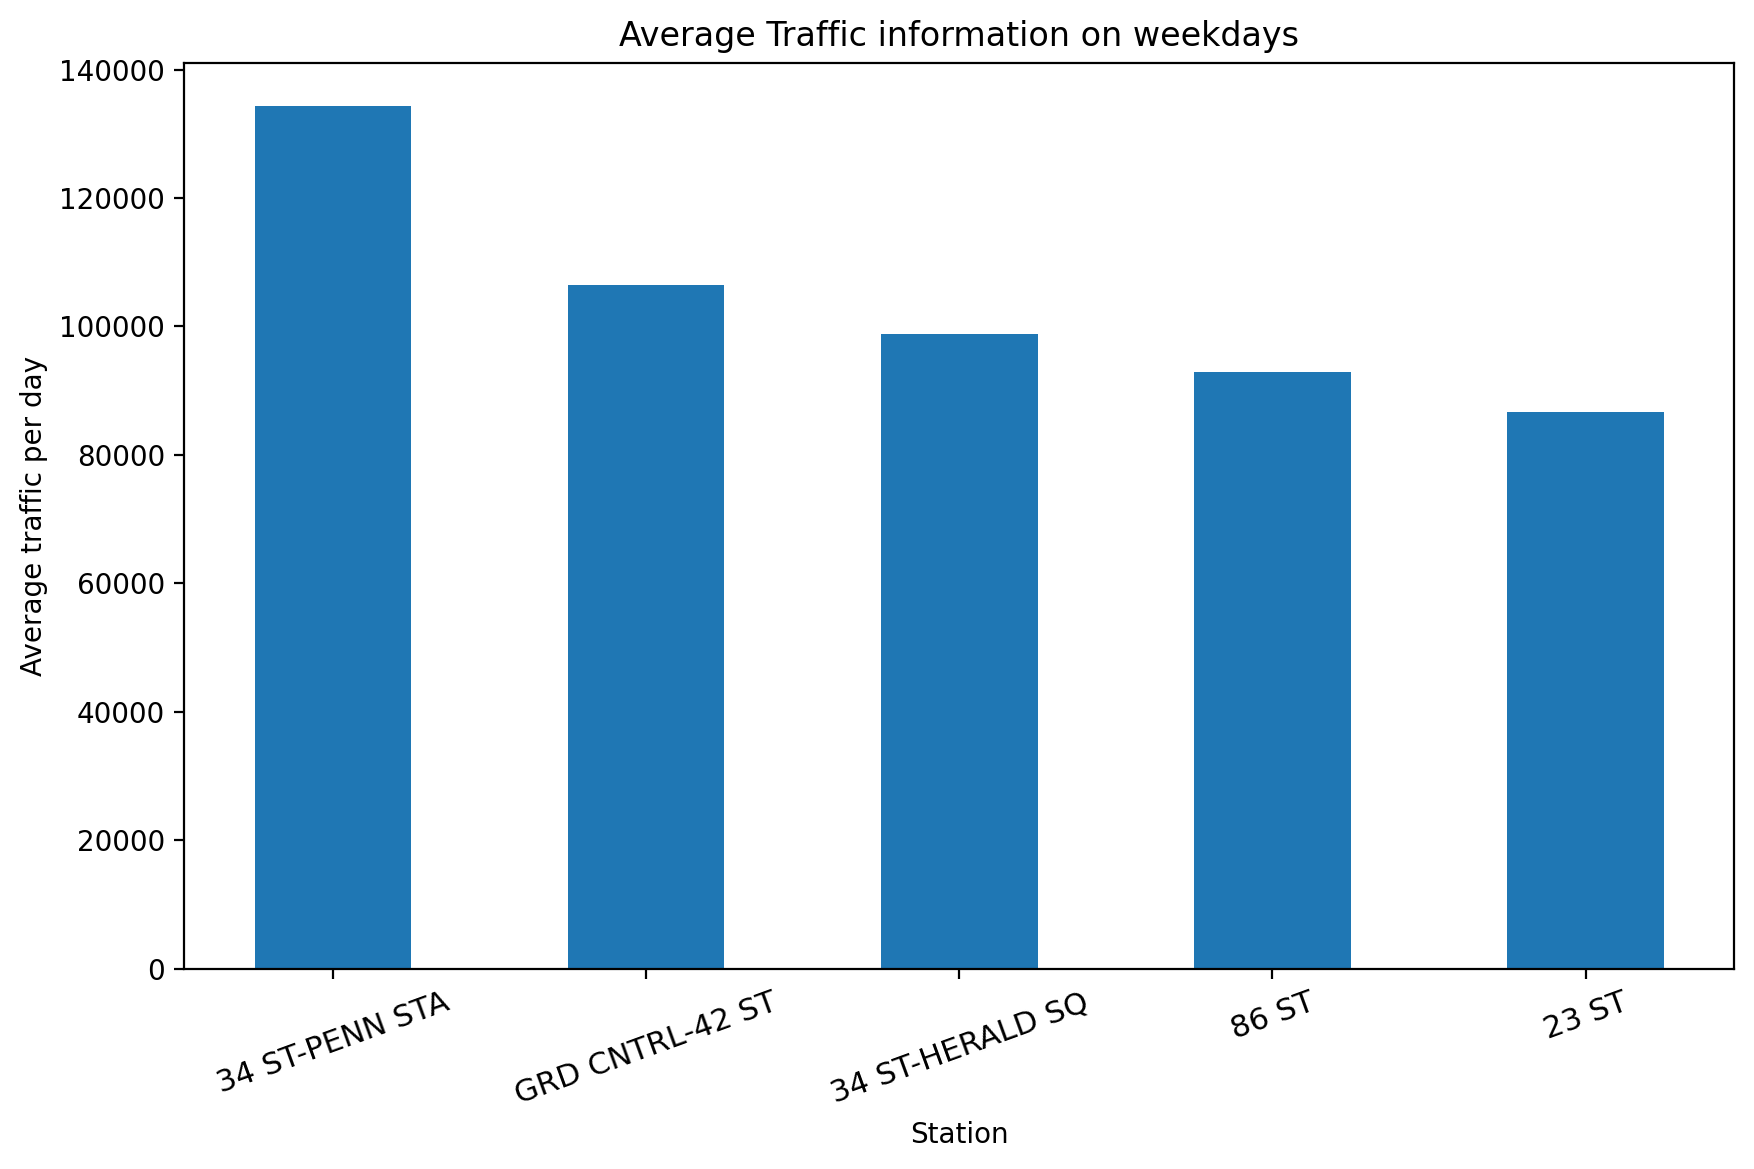

In [166]:
# generate chart

wt = wt.head(5)
fig_avg_wd = plt.figure(figsize=(10, 6), dpi=200)
plt.bar(wt['STATION'], wt['AVG_TRAFFIC'], width = 0.5)
plt.xticks(fontsize=11, rotation = 20)
plt.xlabel('Station')
plt.ylabel('Average traffic per day')
plt.title('Average Traffic information on weekdays')
fig_avg_wd.savefig('Average_traffic_weekdays.png', dpi=200) 

In [114]:
# get traffic informations on weekends

weekend_traffic = daily_traffic[daily_traffic['IS_WEEKDAY'] == False]

In [115]:
# average traffic for each station on weekends
dic = {'DAILY_TRAFFIC': 'mean'}
we = weekend_traffic.groupby('STATION').agg(dic)
# sort
we.sort_values('DAILY_TRAFFIC', ascending = False, inplace = True)
we.reset_index(inplace = True)
# rename the column
we.rename(columns = {'DAILY_TRAFFIC': 'AVG_TRAFFIC'}, inplace = True)
we = we.round({'AVG_TRAFFIC': 2})

we.head()

,STATION,AVG_TRAFFIC
0,CLEVELAND ST,195730.56
1,34 ST-PENN STA,85986.88
2,34 ST-HERALD SQ,66821.53
3,FULTON ST,60950.00
4,TIMES SQ-42 ST,59166.59


## Average traffic on weekends

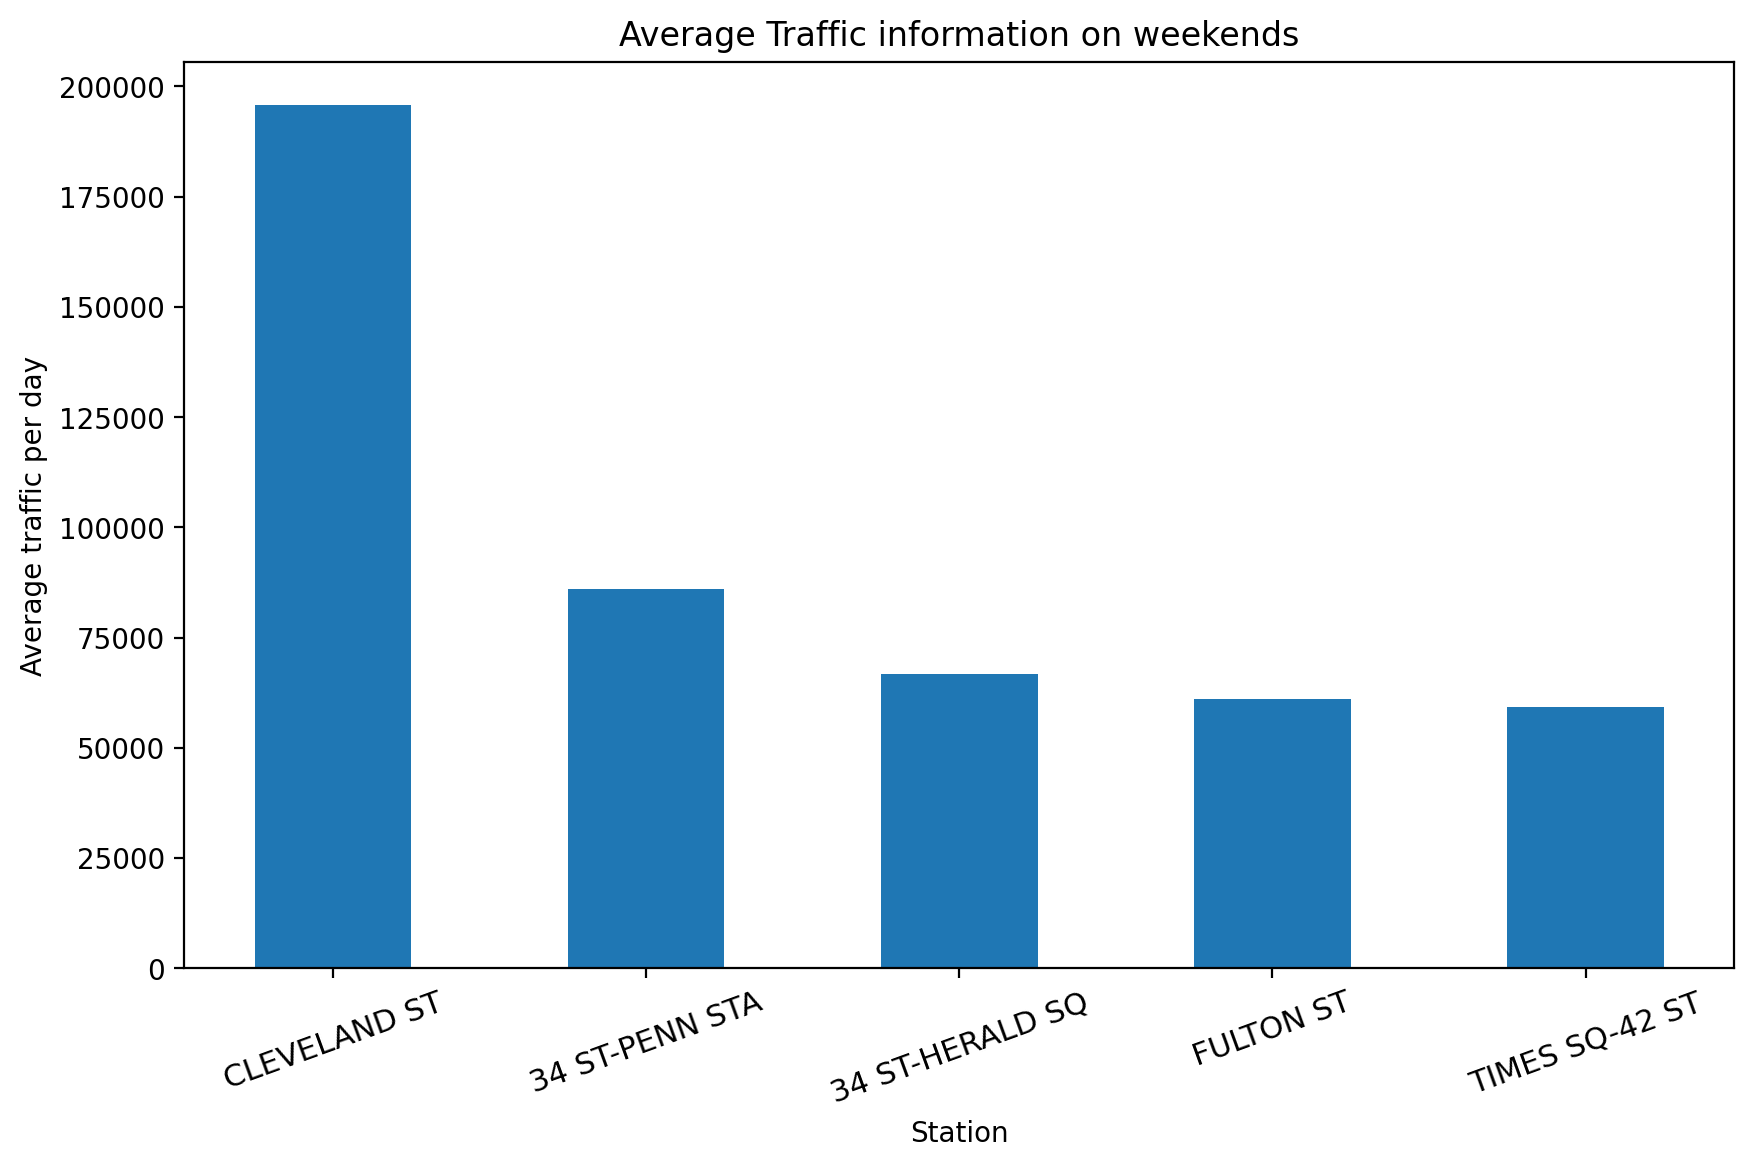

In [167]:
# generate chart

we = we.head(5)
fig_avg_we = plt.figure(figsize=(10, 6), dpi=200)
plt.bar(we['STATION'], we['AVG_TRAFFIC'], width = 0.5)
plt.xticks(fontsize=11, rotation = 20)
plt.xlabel('Station')
plt.ylabel('Average traffic per day')
plt.title('Average Traffic information on weekends')
fig_avg_we.savefig('Average_traffic_weekends.png', dpi=200) 

In [117]:
date_time.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,TRAFFIC,DAILY_TRAFFIC
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,07:00:00,REGULAR,7672969,2645040,2021-12-18 07:00:00,10318009,20
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,11:00:00,REGULAR,7672991,2645127,2021-12-18 11:00:00,10318118,109
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,15:00:00,REGULAR,7673037,2645193,2021-12-18 15:00:00,10318230,112
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,19:00:00,REGULAR,7673097,2645270,2021-12-18 19:00:00,10318367,137
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,23:00:00,REGULAR,7673128,2645283,2021-12-18 23:00:00,10318411,44


In [118]:
# add is_weekday to date_time

date_time['IS_WEEKDAY'] = date_time.DATE_TIME.dt.dayofweek < 5
date_time = date_time[date_time['DAILY_TRAFFIC'] < 1000000]
date_time.reset_index(inplace = True)

In [119]:
# traffic every 4 hours on weekdays for the first 3 most crowded stations

hourly_traffic = date_time.groupby(['STATION', 'TIME', 'IS_WEEKDAY']).agg('mean')
hourly_traffic.reset_index(inplace=True)
hourly_traffic = hourly_traffic.round({'DAILY_TRAFFIC': 2})

In [120]:
# select data on weekdays

weekday_hourly = hourly_traffic[hourly_traffic.IS_WEEKDAY == True]

weekday_hourly.head()

,STATION,TIME,IS_WEEKDAY,index,ENTRIES,EXITS,TRAFFIC,DAILY_TRAFFIC
1,1 AV,00:00:00,True,2.451501e+06,1.935379e+07,1.956756e+07,3.892135e+07,137.72
3,1 AV,03:00:00,True,6.720171e+05,1.982548e+07,2.003707e+07,3.986255e+07,41.18
5,1 AV,04:00:00,True,2.450363e+06,1.936995e+07,1.958368e+07,3.895363e+07,23.03
7,1 AV,07:00:00,True,6.720181e+05,1.982549e+07,2.003711e+07,3.986260e+07,43.16
8,1 AV,07:03:05,True,2.556048e+06,8.893686e+05,3.816486e+06,4.705855e+06,44.40


In [121]:
weekday_station_names = []
weekdays = []
for i in range(5):
    tmp = wt.loc[i].STATION
    tmp2 = weekday_hourly[weekday_hourly.STATION == tmp]
    tmp2.TIME = pd.to_datetime(tmp2.TIME)
    # combine some hours
    tmp3 = pd.DataFrame()
    tmp3['TIME'] = ['0-9', '9-12', '12-14', '14-17', '17-22', '22-24']
    arr = []
    arr.append(tmp2[tmp2.TIME.dt.hour.isin(np.arange(0, 9))].DAILY_TRAFFIC\
               .agg('sum'))
    arr.append(tmp2[tmp2.TIME.dt.hour.isin(np.arange(9, 12))].DAILY_TRAFFIC\
               .agg('sum'))
    arr.append(tmp2[tmp2.TIME.dt.hour.isin(np.arange(12, 14))].DAILY_TRAFFIC\
               .agg('sum'))
    arr.append(tmp2[tmp2.TIME.dt.hour.isin(np.arange(14, 17))].DAILY_TRAFFIC\
               .agg('sum'))
    arr.append(tmp2[tmp2.TIME.dt.hour.isin(np.arange(17, 22))].DAILY_TRAFFIC\
               .agg('sum'))
    arr.append(tmp2[tmp2.TIME.dt.hour.isin(np.arange(22, 24))].DAILY_TRAFFIC\
               .agg('sum'))
    
    tmp3['TRAFFIC'] = arr

    weekday_station_names.append(tmp)
    weekdays.append(tmp3)

/var/folders/zv/mh_k3lbx3pj2g9l7ylz3621r0000gn/T/ipykernel_9642/18730955.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp2.TIME = pd.to_datetime(tmp2.TIME)
/var/folders/zv/mh_k3lbx3pj2g9l7ylz3621r0000gn/T/ipykernel_9642/18730955.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp2.TIME = pd.to_datetime(tmp2.TIME)
/var/folders/zv/mh_k3lbx3pj2g9l7ylz3621r0000gn/T/ipykernel_9642/18730955.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

## Average hourly traffic on weekdays

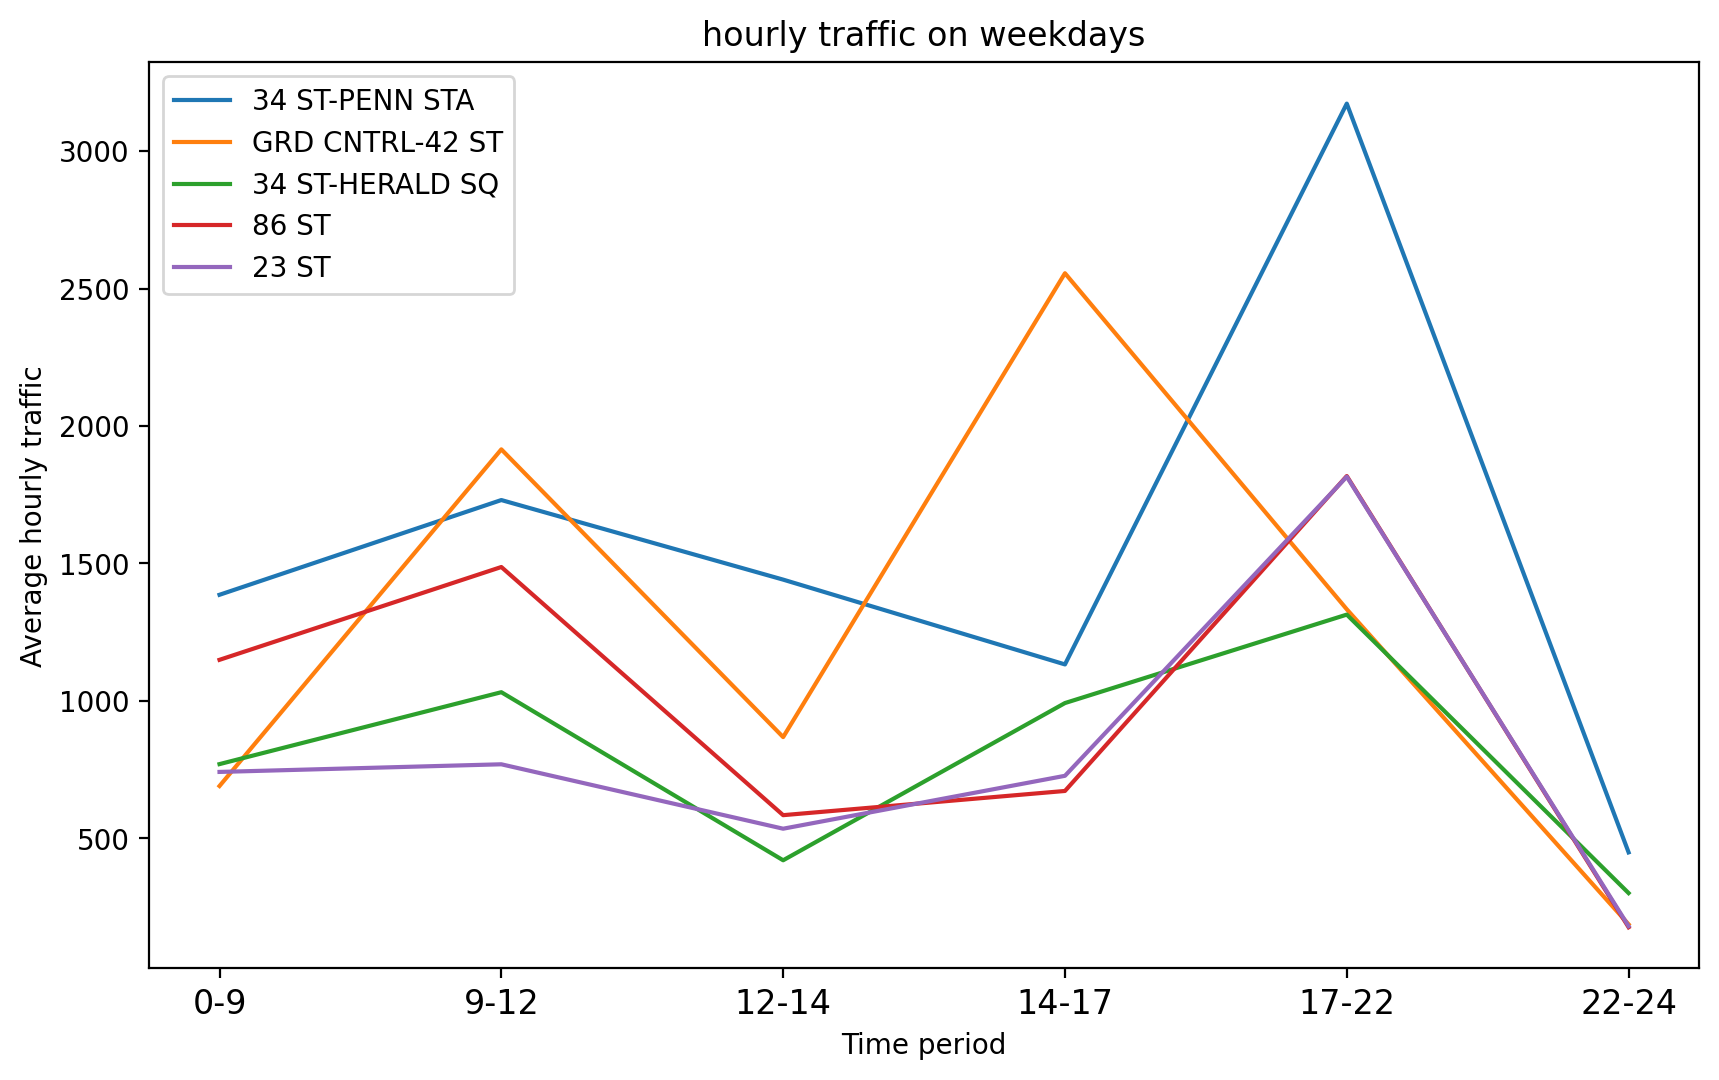

In [164]:
# generate chart
fig_hourly_wd = plt.figure(figsize=(10, 6), dpi=200)
for i in range(len(weekdays)):
    plt.plot(weekdays[i].TIME, weekdays[i].TRAFFIC, label = weekday_station_names[i])
plt.ylabel('Average hourly traffic')
plt.xlabel('Time period')
plt.xticks(fontsize=12)
plt.title('hourly traffic on weekdays')
plt.legend()
fig_hourly_wd.savefig('hourly_traffic_weekdays.png', dpi=200) 

In [170]:
# select data on weekends

weekend_hourly = hourly_traffic[hourly_traffic.IS_WEEKDAY == False]

weekend_hourly.head()

,STATION,TIME,IS_WEEKDAY,index,ENTRIES,EXITS,TRAFFIC,DAILY_TRAFFIC
0,1 AV,00:00:00,False,2.345970e+06,1.662043e+07,1.678929e+07,3.340972e+07,38787.71
2,1 AV,03:00:00,False,6.576487e+05,1.724669e+07,1.742310e+07,3.466979e+07,36233.06
4,1 AV,04:00:00,False,2.394841e+06,1.937558e+07,1.958923e+07,3.896481e+07,81.35
6,1 AV,07:00:00,False,6.229469e+05,1.979724e+07,2.000986e+07,3.980710e+07,28.21
10,1 AV,08:00:00,False,2.394842e+06,1.937558e+07,1.958926e+07,3.896485e+07,38.66


In [124]:
weekend_station_names = []
weekends = []
for i in range(5):
    tmp = we.loc[i].STATION
    tmp2 = weekend_hourly[weekend_hourly.STATION == tmp]
    tmp2.TIME = pd.to_datetime(tmp2.TIME)
    # combine some hours
    tmp3 = pd.DataFrame()
    tmp3['TIME'] = ['0-9', '9-12', '12-14', '14-17', '17-22', '22-24']
    arr = []
    arr.append(tmp2[tmp2.TIME.dt.hour.isin(np.arange(0, 9))].DAILY_TRAFFIC\
               .agg('sum'))
    arr.append(tmp2[tmp2.TIME.dt.hour.isin(np.arange(9, 12))].DAILY_TRAFFIC\
               .agg('sum'))
    arr.append(tmp2[tmp2.TIME.dt.hour.isin(np.arange(12, 14))].DAILY_TRAFFIC\
               .agg('sum'))
    arr.append(tmp2[tmp2.TIME.dt.hour.isin(np.arange(14, 17))].DAILY_TRAFFIC\
               .agg('sum'))
    arr.append(tmp2[tmp2.TIME.dt.hour.isin(np.arange(17, 22))].DAILY_TRAFFIC\
               .agg('sum'))
    arr.append(tmp2[tmp2.TIME.dt.hour.isin(np.arange(22, 24))].DAILY_TRAFFIC\
               .agg('sum'))
    
    tmp3['TRAFFIC'] = arr
    tmp3['TRAFFIC'] = tmp3.TRAFFIC.astype(int)

    weekend_station_names.append(tmp)
    weekends.append(tmp3)

/var/folders/zv/mh_k3lbx3pj2g9l7ylz3621r0000gn/T/ipykernel_9642/4159009859.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp2.TIME = pd.to_datetime(tmp2.TIME)
/var/folders/zv/mh_k3lbx3pj2g9l7ylz3621r0000gn/T/ipykernel_9642/4159009859.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp2.TIME = pd.to_datetime(tmp2.TIME)
/var/folders/zv/mh_k3lbx3pj2g9l7ylz3621r0000gn/T/ipykernel_9642/4159009859.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

## Average hourly traffic on weekends

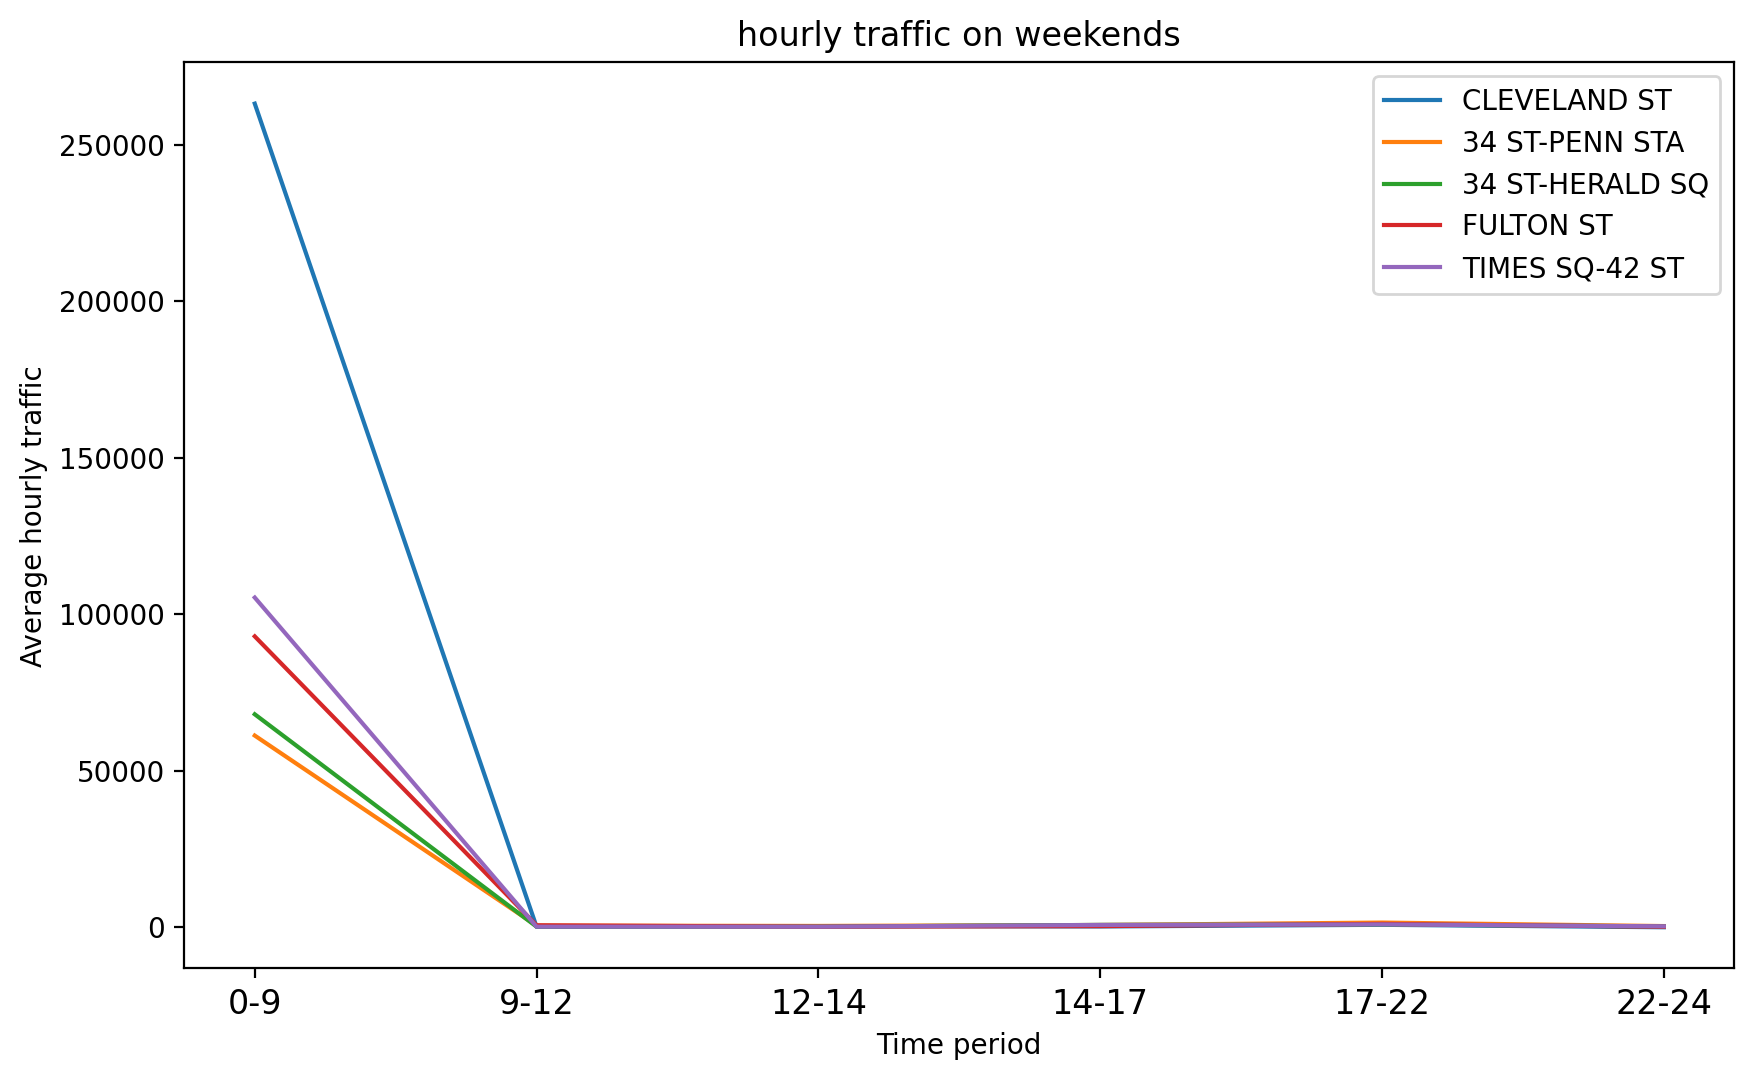

In [168]:
# generate chart
fig_hourly_we = plt.figure(figsize=(10, 6), dpi=200)
for i in range(len(weekdays)):
    plt.plot(weekends[i].TIME, weekends[i].TRAFFIC, label = weekend_station_names[i])
plt.ylabel('Average hourly traffic')
plt.xlabel('Time period')
plt.xticks(fontsize=12)
plt.title('hourly traffic on weekends')
plt.legend()
fig_hourly_we.savefig('hourly_traffic_weekends.png', dpi=200) 

## Handling coordinates

In [126]:
station_coords = pd.read_csv('subway_station_coordinates.csv')
station_coords['NAME'] = station_coords.NAME.str.upper()

In [127]:
weekday_coords = coords[coords.NAME.isin(weekday_station_names)]
weekday_coords

,Unnamed: 0,NAME,lat,lon
30,30,GRD CNTRL-42 ST,-73.976713,40.751807
80,85,86 ST,-73.976218,40.788644
85,91,23 ST,-73.986599,40.739864
127,144,34 ST-HERALD SQ,-73.987937,40.749645
286,357,34 ST-PENN STA,-73.991057,40.750373


## Locations of stations that are busy during weekdays

In [189]:
weekday_map = f.Map(location=[weekday_coords.lon.mean(), weekday_coords.lat.mean()],\
                    zoom_start=12, control_scale=True)
for index, info in weekday_coords.iterrows():
    f.Marker([info['lon'], info['lat']], popup=info['NAME']).add_to(weekday_map)
# weekday_map.save('weekday_station_map.png')
for index, info in com_coords.iterrows():
    f.CircleMarker([info['lon'], info['lat']], popup=info['NAME'], color='red').add_to(weekday_map)
weekday_map

In [130]:
weekend_coords = coords[coords.NAME.isin(weekend_station_names)]
weekend_coords

,Unnamed: 0,NAME,lat,lon
75,79,TIMES SQ-42 ST,-73.986768,40.754612
107,117,FULTON ST,-73.975375,40.687119
127,144,34 ST-HERALD SQ,-73.987937,40.749645
180,214,CLEVELAND ST,-73.885194,40.679778
286,357,34 ST-PENN STA,-73.991057,40.750373


## Locations of stations that are busy during weekends

In [188]:
weekend_map = f.Map(location=[weekend_coords.lon.mean(), weekend_coords.lat.mean()],\
                    zoom_start=12, control_scale=True)
for index, info in weekend_coords.iterrows():
    f.Marker([info['lon'], info['lat']], popup=info['NAME']).add_to(weekend_map)
    
for index, info in uni_coords.iterrows():
    f.CircleMarker([info['lon'], info['lat']], popup=info['NAME'], color='red').add_to(weekend_map)

weekend_map

In [154]:
uni_coords

,NAME,lon,lat
0,NYU,40.730066,-73.996590
1,CC,40.804936,-73.960556
2,SUNY,40.692411,-73.989745
3,SPU,40.729096,-74.070384
4,SVA,40.738835,-73.982319


## Some universities in New York City

In [158]:
uni_map = f.Map(location=[uni_coords.lon.mean(), uni_coords.lat.mean()],\
                    zoom_start=12, control_scale=True)
for index, info in uni_coords.iterrows():
    f.Marker([info['lon'], info['lat']], popup=info['NAME']).add_to(uni_map)

uni_map

## Big companies in New York City

In [160]:
com_map = f.Map(location=[com_coords.lon.mean(), com_coords.lat.mean()],\
                    zoom_start=12, control_scale=True)
for index, info in com_coords.iterrows():
    f.Marker([info['lon'], info['lat']], popup=info['NAME']).add_to(com_map)

com_map